# Reseaux de Neurones Confolutifs (CNNs)

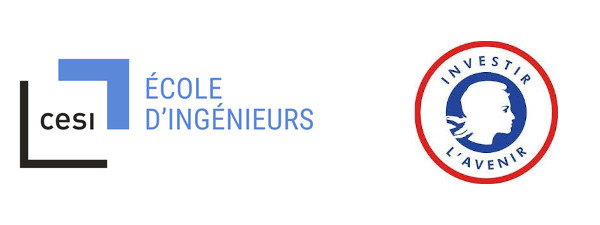

|Auteur|Centre|Modification|
|---|---|---|
|Nassim HADDAM|Nanterre|2020/12/08|

L'objectif de de ce workshop est de vous faire acquérir les notions de base sur les réseaux de neurones convolutifs (CNNs). Les réseaux de neurones convolutifs (CNNs) constituent une architecture spéciale permettant de faire de l'apprentissage de taches ayant trait à la vision par ordinateur. L'application que vous allez effectuer consiste à classifier des images de fleurs. Le dataset vous est fourni, et vous allez être guidé tout au long du workshop. Vous allez travailler essentiellement avec [`keras`](https://keras.io/api/) qui est une bibliothèque opensource pour faire du deep learning, et qui a été intégré à la version 2 de [`tensorflow`](https://www.tensorflow.org/). 

# 1. Chargement des données et consitution du jeu de données

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Nous commençons par télécharger les images que nous allons utiliser pour faire de la classification d'images :

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

Pour commencer, nous devons spécifier quelques paramètres pour l'apprentissage:
<ul>
    <li>La longueur et la largeur des images. </li>
    <li>La taille du batch.</li>
</ul>

In [3]:
image_h = 180
image_w = 180
batch_s = 32

Ensuite, nous devons partager le jeu de données en jeu d'entrainement et en jeu de test. Pour rappel, le jeu d'entrainement servira à entrainer le réseau de neurones, quant au jeu de test il sert à mesurer les performances de votre architecture sur des données qu'il n'a jamais vues auparavant. Le jeu d'entrainement constitue une fraction du jeu de données total (en l'occurrence 80% dans ce travail). Vous utiliserez la fonction [`tf.keras.preprocessing.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory). Cette fonction sert à générer un jeu de données à partir des fichiers d'image dans un répertoire.

**Remarque** : L'algorithme d'apprentissage ne doit **jamais** voir le jeu de test ni s'entrainer sur les exemples le constituant, cela biaiserait les résultats obtenus.

In [10]:
# Le train_set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=  0.2,
    subset =  "training",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s
)
# Le test_set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=  0.2,
    subset =  "validation",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Le sortie précise qu'on a 3670 fichiers au complet dont 2936 appartenant au jeu d'entrainement et 734 au jeu de test. Maintenant que le jeu de données est prêt, il faut explorer/visualiser les données pour avoir une meilleure intuition de ce qui se passe.

# 2. Exploration et visualisation des données
Commençons, tout d'abord par afficher le nom des classes. On sait qu'on s'intéresse aux fleurs, mais on ne sait meme pas lesquelles.

In [11]:
class_names = train_set.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Le résultat et bel et bien affiché. En français, ça donne `['marguerite', 'pissenlit', 'roses', 'tournesols', 'tulipes']`. Affichons ensuite avec [matplotlib.pyplot.subplot](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplot.html) quelques images pour voir à quoi ces classes correspondent.

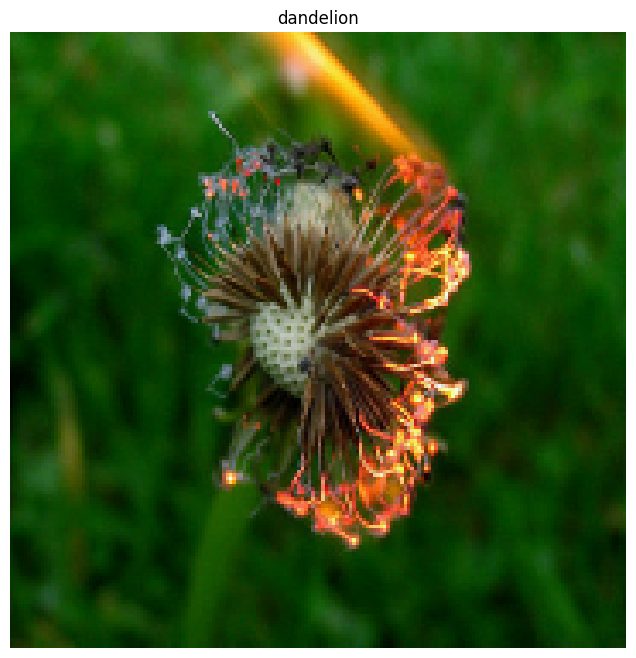

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_set.take(1):
    for i in range(9):
        ax =  plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

On voit bien qu'il y a différents types de fleurs. Il y a, en apparence, un seul type de fleur par image (ce serait compliqué de faire de la classification autrement).

Cependant, on note un certain nombre d'éléments qui peuvent compliquer l'interprétation des images. Une image peut représenter une ou plusieurs fleurs du même type, l'angle de la photo n'est pas toujours le même ainsi que la luminosité, la distance de l'objectif aux fleurs etc. L'arrière-plan peut aussi varier énormément d'une image à l'autre. Enfin, on a aussi parfois d'autres objets dans l'image, qu'ils soient présents dans la nature (abeilles) ou parfois non (sacs). Heureusement, nous avons à notre disposition des outils pour traiter de ce genre de problème, nous le verrons plus bas.

On voudrait aussi connaître la taille des données, ça pourrait être utile pour gérer les performances du modèle. Dans la cellule ci-dessous, le type de `train_set` est [`BatchDataset`](https://www.tensorflow.org/api_docs/python/tf/raw_ops/BatchDataset), c'est un objet contenant les batchs d'images. On prend un élément de `train_set` et on affiche le premier batch. C'est un tenseur (matrice à $n$ dimensions) de la forme (32, 180, 180, 3). Ce tenseur représente un batch de 32 images de dimensions 180x180x3 (la dernière dimension représente les canaux RVB). La variable `label_batch` est un tenseur de la forme (32,), il contient les labels des images du batch.

In [14]:
print(type(train_set))
images, labels =  next(iter(train_set))
print(images.shape)
print(labels.shape)

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
(32, 180, 180, 3)
(32,)


Il est maintenant temps de configurer notre environnement pour passer au vif du sujet.

# 3. Configuration de l'environnement pour l'entrainement
Dans cette partie, vous devrez utiliser les fonctions [`Dataset.cache`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) et [`Dataset.prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) afin de configurer les données pour améliorer les performances de la façon suivante :
- `Dataset.cache()` : Cette fonction sert à forcer le maintien des données en cache dans la mémoire. Vu que le réseau de neurones fait plusieurs passes (qu'on nomme _époque_ ou _epoch_ en anglais) sur les données durant l'apprentissage, cette fonction permet de ne pas avoir à recharger les images à chaque fois. 
- `Dataset.prefetch()` : Cette fonction permet de faire le prétraitement de l'élément courant du jeu de données (par exemple le batch suivant) en même temps que l'entrainement/évaluation du batch courant par le modèle. Dans un environnement multi-processeurs ou multi-cœur, c'est un gain de temps non négligeable.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

# 4. La normalisation
Généralement, en machine learning, vous aurez souvent besoin de transformer l'échelle de valeur des attributs de sorte que les attributs prennent des valeurs qui sont dans le même intervalle. Cette transformation aura pour effet de rendre l'apprentissage plus uniforme au niveau des différents attributs et donc de ne pas surestimer l'importance d'un attribut par rapport à un autre (cela peut arriver si par exemple les attributs ont des échelles complètement différentes). Dans ce workshop vous allez appliquer [la normalisation](https://medium.com/@darrenyaoyao.huang/why-we-need-normalization-in-deep-learning-from-batch-normalization-to-group-normalization-d06ea0e59c17) qui consiste juste à diviser l'entrée (la valeur d'une composante RVB d'un pixel) par 255 pour transformer l'entrée dans l'intervalle [0, 1]. Ce traitement se fait à l'aide de la fonction [`layers.experimental.preprocessing.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling).

# 5. Le modèle de réseau de neurones convolutif (CNN)
Le CNN est une architecture spécialisée de réseau de neurones qui a été créé afin d’apprendre efficacement les taches de vision par ordinateur. Un exemple de cette architecture est illustré ci-dessous. La particularité de ces réseaux de neurones est l’introduction de couches convolutives au niveau des couches cachées :
-	Vous avez vu dans le workshop de traitement d’images que les opérations de convolution servent à extraire divers caractéristiques et informations contenues dans l’image (nous avons vu la détection de [contours]( https://fr.wikipedia.org/wiki/D%C3%A9tection_de_contours), mais il y aussi la détection de [coins]( https://en.wikipedia.org/wiki/Corner_detection), et aussi la détection de [blob]( https://en.wikipedia.org/wiki/Blob_detection)). 
-	Vous savez aussi depuis le workshop précédent que dans les réseaux de neurones, les neurones des couches profondes se basent sur les neurones des premières couches pour détecter des attributs de plus haut niveau de la donnée en entrée. Pour les images, par exemple, les caractéristiques de bas niveau sont celles mentionnées dans le point précédent (contours, coins, blobs...), et les caractéristiques de haut niveau pourraient être la présence de certaines motifs, textures, formes construites partant des attributs de bas niveau.
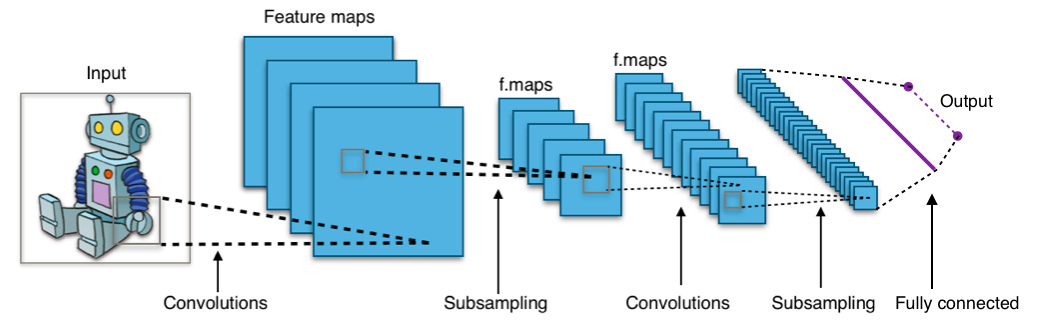
Les réseaux de neurones convolutifs combinent les deux idées précédentes pour former des réseaux dont certains neurones servent à représenter des informations plus ou moins locales sur les images à travers l’application de l’opération de convolution. Ces neurones (issus de couches dites convolutives) ne sont connectés qu’à des neurones voisins de la couche précédente. La sortie de ces mêmes neurones est obtenue par l’application de filtres convolués sur la couche précédente. Ces filtres représentent les poids de la couche convolutive et servent à décrire des attributs de l’images appris à partir du dataset. Un exemple de convolution au niveau de la couche convolutive vous est donné ci-dessous (et qui est tiré de ce [lien](https://cs231n.github.io/convolutional-networks/)). Pouvez-vous dire pourquoi il est plus intéressant d’opter pour une architecture par réseaux de neurones convolutifs au lieu de garder l’architecture classique pour les taches de vision par ordinateur ?
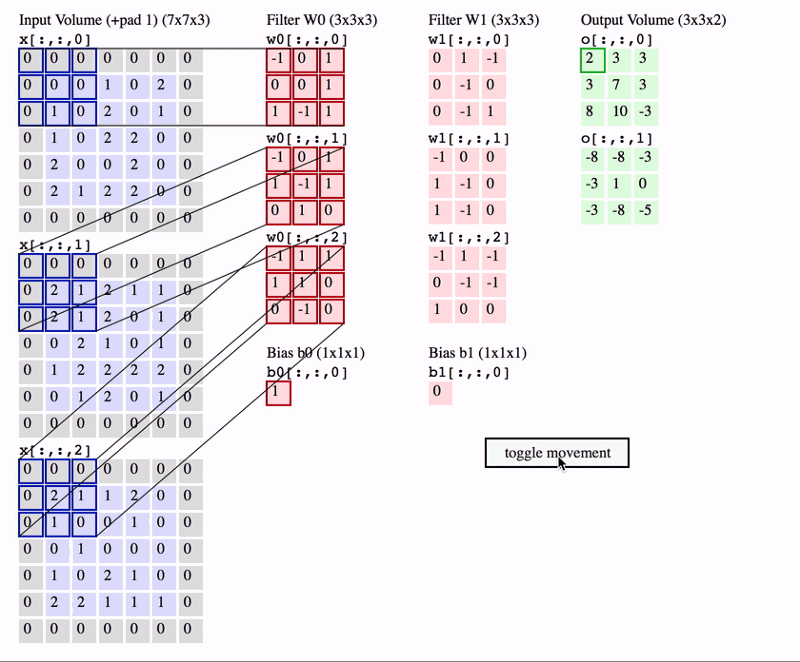

<em>ChatGPT : 

L'utilisation d'architectures de réseaux de neurones convolutifs (CNN) plutôt que d'architectures classiques pour les tâches de vision par ordinateur présente plusieurs avantages significatifs. Voici quelques-unes des raisons pour lesquelles les CNN sont préférés dans ce contexte :

Extraction de caractéristiques hiérarchiques : Les CNN sont spécialement conçus pour extraire automatiquement des caractéristiques à différentes échelles et niveaux d'abstraction à partir d'images. Contrairement aux méthodes classiques où il faut généralement concevoir manuellement des caractéristiques, les CNN apprennent ces caractéristiques directement à partir des données.

Invariance aux translations : Les CNN utilisent des opérations de convolution et de sous-échantillonnage (pooling) qui leur permettent d'être invariants aux translations. Cela signifie que le réseau peut reconnaître des objets dans différentes parties de l'image, ce qui est essentiel pour la détection d'objets et la reconnaissance d'objets dans des images.

Capacité de généralisation : Les CNN ont montré une grande capacité à généraliser à partir de données d'entraînement limitées. Ils peuvent apprendre des modèles qui fonctionnent bien sur de nouvelles données, ce qui est essentiel pour la vision par ordinateur, où les données peuvent être très variables.

Empilement de couches profondes : Les architectures CNN modernes sont souvent très profondes, ce qui leur permet d'apprendre des représentations de plus en plus abstraites des données. Cela permet au réseau de capturer des informations complexes et de résoudre des tâches de vision par ordinateur difficiles.

Performances supérieures : Dans de nombreuses tâches de vision par ordinateur, les CNN ont démontré des performances supérieures par rapport aux méthodes classiques. Ils ont notamment remporté de nombreuses compétitions de détection d'objets, de segmentation sémantique, de classification d'images, etc.

Transfert de connaissances : Les CNN pré-entraîés sur de grandes bases de données d'images (comme ImageNet) peuvent être utilisés comme point de départ pour de nombreuses tâches de vision par ordinateur. Cette technique, appelée transfert de connaissances, permet d'exploiter les connaissances apprises sur des tâches similaires pour améliorer les performances sur de nouvelles tâches avec des ensembles de données plus petits.

Évolution continue : Les architectures de CNN continuent d'évoluer avec de nouvelles innovations, ce qui signifie que les performances continuent de s'améliorer au fil du temps.

En résumé, les CNN sont devenus la norme en vision par ordinateur en raison de leur capacité à apprendre des caractéristiques pertinentes directement à partir des données, de leur capacité à généraliser, de leur résilience aux variations et de leurs performances globalement supérieures par rapport aux méthodes classiques. Ils ont révolutionné le domaine de la vision par ordinateur et ont ouvert la voie à de nombreuses applications innovantes telles que la détection d'objets, la reconnaissance faciale, la segmentation sémantique, etc.</em>

Après ces discussions théoriques sur les CNNs, passons maintenant au code. Pour coder votre modèle, vous devez tout d'abord créer un modèle vide à l'aide de la fonction [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) de tensorflow. La suite de cette partie vous guidera dans l'implémentation d'un modèle potentiel pour la classification d'image, elle introduira aussi quelques notions sur les réseaux de neurones convolutifs.

In [33]:
num_classes = 5 # Nombre de classes et donc aussi nombre de neurones dans la dernière couche
model = Sequential()

Généralement, en machine learning, vous aurez souvent besoin de transformer l'échelle de valeur des attributs de sorte que les attributs prennent des valeurs qui sont dans le même intervalle. Cette transformation aura pour effet de rendre l'apprentissage plus uniforme au niveau des différents attributs et donc de ne pas surestimer l'importance d'un attribut par rapport à un autre (cela peut arriver si par exemple les attributs ont des échelles complètement différentes). 

Dans ce workshop vous allez appliquer [la normalisation](https://medium.com/@darrenyaoyao.huang/why-we-need-normalization-in-deep-learning-from-batch-normalization-to-group-normalization-d06ea0e59c17) qui consiste juste à diviser l'entrée (la valeur d'une composante RVB d'un pixel) par 255 pour transformer l'entrée dans l'intervalle [0, 1]. Vous utiliserez la couche [`layers.experimental.preprocessing.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) à cet effet.

In [34]:
model.add(layers.experimental.preprocessing.Rescaling(1./255))

Après cela, vous allez implémenter votre premier **bloc convolutif**. Un bloc convolutif est constitué de deux couches spécifiques aux réseaux de neurones convolutifs : la [couche convolutive](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif#Couche_de_convolution_(CONV)) (qui a été introduite brièvement), et la [couche de pooling](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif#Couche_de_pooling_(POOL)). Pour plus de détails sur ces couches au niveau, [ce Notebook](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_2_cnn.ipynb) sera utile. Les architectures gèrent ces couches de manière potentiellement différentes, mais il est courant d'utiliser ces couches de la manière suivante :

- La couche convolutive: Elle sert à détecter la présence d'attributs au niveau de l'image en utilisant l'opération de convolution, et ainsi extraire de plus en plus de caractéristiques. L'application de cette couche vise généralement à retourner des attributs de plus haut niveau sur l'image. Elle a pour effet d’augmenter la profondeur de l’image si le nombre de filtres est assez grand. Dans ce workshop, vous devez faire un [padding](https://ayeshmanthaperera.medium.com/what-is-padding-in-cnns-71b21fb0dd7) de sorte que la taille de la sortie reste la même par rapport à l'entrée. Il devrait y avoir 16 filtres de taille `(3,3)` dans cette première couche. N'oubliez pas que la sortie de cette couche doit être passée à une fonction d'activation (la fonction ReLU).

- La couche de pooling : Elle sert à compresser la sortie de la couche convolutive en prenant l'information la plus saillante de celle-ci. La sortie de la couche convolutive est divisée en blocs carrés de même taille. Pour chaque bloc la valeur maximale est retenue et les autres sont ignorés, la hauteur et la largeur de la couche sont réduites.

Faire passer la sortie d’une couche à un bloc de convolution permet d’un coté de déceler des attributs de plus haut niveau en combinant ceux de la couche précédente, d’un autre côté de réduire le nombre de neurones de façon à prendre les neurones les plus actives et qui sont nécessaires à la tache (grace à la couche de pooling). Vous devez donc ajuter les deux couches en vous référant à la [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/). Précisons qu'on vous demande de faire un pooling qui prend le maximum et que l'entrée consiste en des images 2D.

In [35]:
# Couche de convolution
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
# Couche de pooling
model.add(layers.MaxPooling2D((2, 2)))

Implémentez le reste du réseau. Celui-ci devra contenir les éléments suivants :
- Un bloc convolutif similaire au précédent contenant 32 filtres de hauteur et de largeur de 3.
- Un bloc convolutif similaire au précédent contenant 64 filtres de hauteur et de largeur de 3.
- Une couche contenant la couche précédente aplatie (flatten).
- Une couche entièrement connectée de taille 128.
- La couche finale complètement connectée (dense) retournant le résultat de la classification.

Quelques remarques devront être relevées au sujet de cette architecture, vous pouvez vous appuyer sur le premier schéma de CNN pour suivre les remarques de cette partie :
- Les CNNs sont généralement constitués de deux parties, une partie composée de blocs convolutifs, et une partie composée de couches denses. La première partie sert, indirectement, à compresser la taille de l’image pour la remettre en entrée à la deuxième partie qui aura beaucoup moins de neurones que le nombre d’origine de pixels de l’images.
- Les couches de la partie de blocs convolutifs gagnent en profondeur et perdent en hauteur et en largeur à mesure qu’on avance vers des couches profondes dans le réseau. Nous avons besoin de cela car le réseau a besoin d’apprendre à reconnaitre des attributs descriptifs de l’image pour faire de la classification. Le nombre d’attributs s’accroit à mesure qu’on avance dans le réseau, ceci signifie que les neurones des couches profondes perdent en informations spatiales mais gagnent en information descriptives sur l’image.
Quel est l’intérêt en mémoire et en temps de calcul de l’utilisation des architectures par réseau de neurones convolutifs ? (Intéressez-vous au nombre de paramètres).
<em>ChatGPT :
- L'utilisation des architectures de réseaux de neurones convolutifs (CNN) présente des avantages significatifs en termes de mémoire et de temps de calcul par rapport à certaines architectures classiques, en particulier en ce qui concerne le nombre de paramètres. Voici comment les CNN se comparent sur ces aspects :

Réduction du nombre de paramètres : Les CNN sont conçus pour partager les poids (paramètres) entre les neurones, ce qui permet de réduire considérablement le nombre de paramètres par rapport à une architecture classique entièrement connectée. Dans un réseau entièrement connecté, chaque neurone est connecté à chaque neurone de la couche précédente, ce qui entraîne un nombre de paramètres quadratique en fonction du nombre de neurones. En revanche, dans un CNN, les opérations de convolution réduisent considérablement le nombre de connexions, ce qui réduit le nombre de paramètres et la quantité de mémoire nécessaire pour stocker le modèle.

Utilisation efficace de la mémoire : En raison de la réduction du nombre de paramètres, les CNN utilisent la mémoire de manière beaucoup plus efficace que les réseaux entièrement connectés. Cela permet de traiter des images de grande résolution avec des quantités de mémoire raisonnables.

Traitement parallèle : Les opérations de convolution dans les CNN peuvent être parallélisées efficacement, ce qui permet d'accélérer considérablement le temps de calcul. Les GPU (unités de traitement graphique) sont particulièrement bien adaptés à l'accélération des calculs dans les CNN en raison de leur capacité à effectuer de nombreuses opérations en parallèle.

Taille des filtres et des couches : Les CNN utilisent généralement des filtres de petite taille (par exemple, 3x3 ou 5x5) dans leurs couches de convolution, ce qui permet de capturer des motifs locaux. Cela réduit également le nombre de paramètres par rapport à des filtres de grande taille.

Pooling : Les opérations de sous-échantillonnage (pooling) réduisent la résolution spatiale des cartes de caractéristiques, ce qui diminue la quantité de données à traiter. Cela contribue également à réduire le temps de calcul.

En résumé, les CNN sont plus efficaces en termes de mémoire et de temps de calcul par rapport aux architectures classiques en grande partie en raison de leur capacité à réduire le nombre de paramètres grâce à la convolution, au partage de poids et à l'utilisation de filtres de petite taille. Cela les rend adaptés au traitement d'images et à d'autres tâches de vision par ordinateur, où l'efficacité en mémoire et en calcul est cruciale, en particulier lorsque l'on traite des ensembles de données volumineux.</em>


In [36]:
# Bloc convolutif ou la taille du filtre est de (32, 3)
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))

# Bloc convolutif ou la taille du filtre est de (64, 3)
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

# Applatissement de la couche
model.add(layers.Flatten())

# Couche entièrement connectée (couche dense)
model.add(layers.Dense(128, activation='relu'))

# Couche entièrement connectée retournant le résultat de la classification
model.add(layers.Dense(num_classes))

model.build((None, image_h, image_w, 3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 flatten_5 (Flatten)         (None, 518400)            0         
                                                      


Choisissons donc cette métrique et compilons le modèle.

In [37]:
model.compile(optimizer =  'adam',
              loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 flatten_5 (Flatten)         (None, 518400)            0         
                                                      

Finalement, vous avez à préciser l'évolution de l'erreur d'entrainement et la comparer à l'erreur de test. Précisons que l'entrainement requiert le jeu d'entrainement, le jeu de test ainsi que le nombre d'époques.

Epoch 1/10
92/92 [==============================] - 92s 952ms/step - loss: 2.3718 - accuracy: 0.3702 - val_loss: 1.1404 - val_accuracy: 0.5409
Epoch 2/10
92/92 [==============================] - 80s 866ms/step - loss: 0.9956 - accuracy: 0.6240 - val_loss: 1.0610 - val_accuracy: 0.5599
Epoch 3/10
92/92 [==============================] - 77s 833ms/step - loss: 0.6302 - accuracy: 0.7749 - val_loss: 1.0196 - val_accuracy: 0.6022
Epoch 4/10
92/92 [==============================] - 76s 828ms/step - loss: 0.2952 - accuracy: 0.9080 - val_loss: 1.4128 - val_accuracy: 0.5981
Epoch 5/10
92/92 [==============================] - 75s 820ms/step - loss: 0.1209 - accuracy: 0.9680 - val_loss: 1.5194 - val_accuracy: 0.5886
Epoch 6/10
92/92 [==============================] - 87s 943ms/step - loss: 0.0950 - accuracy: 0.9772 - val_loss: 1.7147 - val_accuracy: 0.5804
Epoch 7/10
92/92 [==============================] - 78s 844ms/step - loss: 0.0344 - accuracy: 0.9925 - val_loss: 1.9181 - val_accuracy: 0.5817

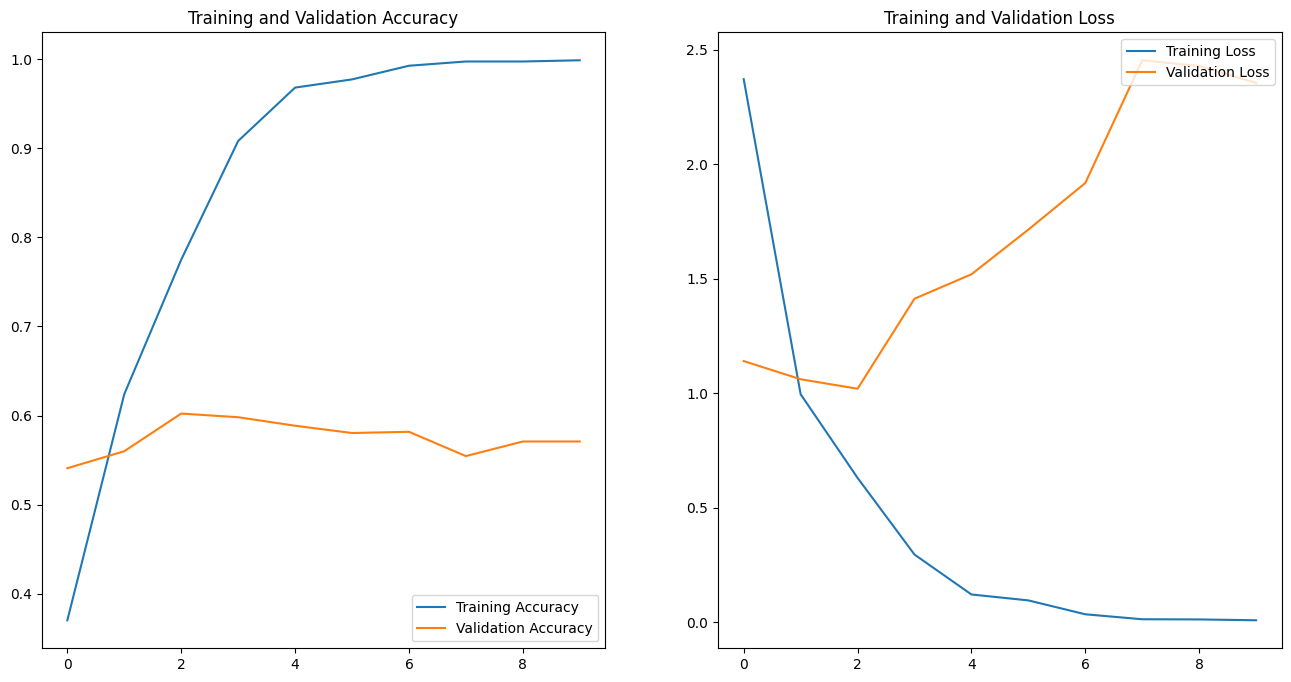

In [38]:
epochs=10
history =  model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Le code de la cellule précédente permet d’entrainer le modèle et de suivre l’évolution de la précision et de la perte sur le jeu de données d’entrainement et de test. Qu’observez-vous au niveau de ces courbes ? Vous y voyez des signes de surentrainement ou de sous-entrainement ? Pourquoi ?
<em>À COMPLÉTER</em>

0n remarque que l’évolution des courbes est assez lisse, que feriez-vous si les courbes étaient très bruitées ?

<em>À COMPLÉTER</em>

Il va donc falloir améliorer les performances de notre algorithme d'apprentissage, et notamment gérer ce problème d'apprentissage. Voyons comment on pourrait s'y prendre.

In [39]:
# la vie de ma mère dis moi que mon gpu fonctionne avec tensorflow
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


pute

# 5. Techniques de régularisation
Les techniques de régularisation sont les techniques qui visent à réduire le surapprentissage. L’objectif est d’éviter que le réseau de neurones mémorise le jeu de données en s’ajustant bêtement sur les particularités du jeu d’entrainement. Il s’agit globalement de réduire les degrés de liberté du réseau de neurones. Dans le cadre de ce wokrshop nous verrons deux techniques de régularisation :
-	**L’augmentation des données** : Avoir plus de données est toujours bon pour réduire le surapprentissage, d’où l’augmentation des données. Le principe et de rajouter de nouvelles images en effectuant des transformations sur le jeu d’entrainement d’origine. Ces nouvelles images sont obtenues par des transformation affines, ou généralement par des transformations réalistes qui ne change pas la nature du label affectée à l’image. Cette technique est très efficace car les réseaux de neurones sont très gourmands en données.
-	**La technique de dropout** : Cette technique consiste à désactiver, à chaque traitement, les neurones d’une couche dense du réseau de manière aléatoire. Le dropout dépend d’un paramètre qui représente la probabilité de désactivation des neurones de la couche. Cette probabilité est le la proportion moyenne de neurones actives dans la couche durant les itérations de l’entrainement. Elle permet de réduire la complexité du réseau de neurones pour réduire le surapprentissage.

Ces techniques sont utilisés afin de réduire le surapprentissage au niveau des réseaux de neurones. Mais pouvez dire pourquoi l’augmentation des données est utile alors que les données générées sont issues du jeu de données d’entrainement ? Il y aurait vraiment plus d’information contenue dans notre jeu de données que celle qui est déjà présente ? Essayez de prendre un exemple d'image et de réfléchir sur ce qui pourrait se passer si on applique une rotation au niveau de cette image.

<em>À COMPLÉTER</em>
Pouvez-vous détailler en quoi le dropout est utile pour gérer les problèmes de surapprentissage ? Quels sont les avantages du dopout ? Il faut penser en termes de taille du modèle et de sa capacité à mémoriser/apprendre les détails spécifiques au jeu de données.
<em>À COMPLÉTER</em>

Dans les cellules qui suivent, vous allez ré-implémenter le modèle et refaire l’entrainement en incluant une couche de dropout (précédent la couche d’aplatissement), le tout en rajoutant une couche d’augmentation de données. Implémentez tout d'abord le réseau précédent en rajoutant seulement le dropout.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 90, 90, 64)        0         
                                                      

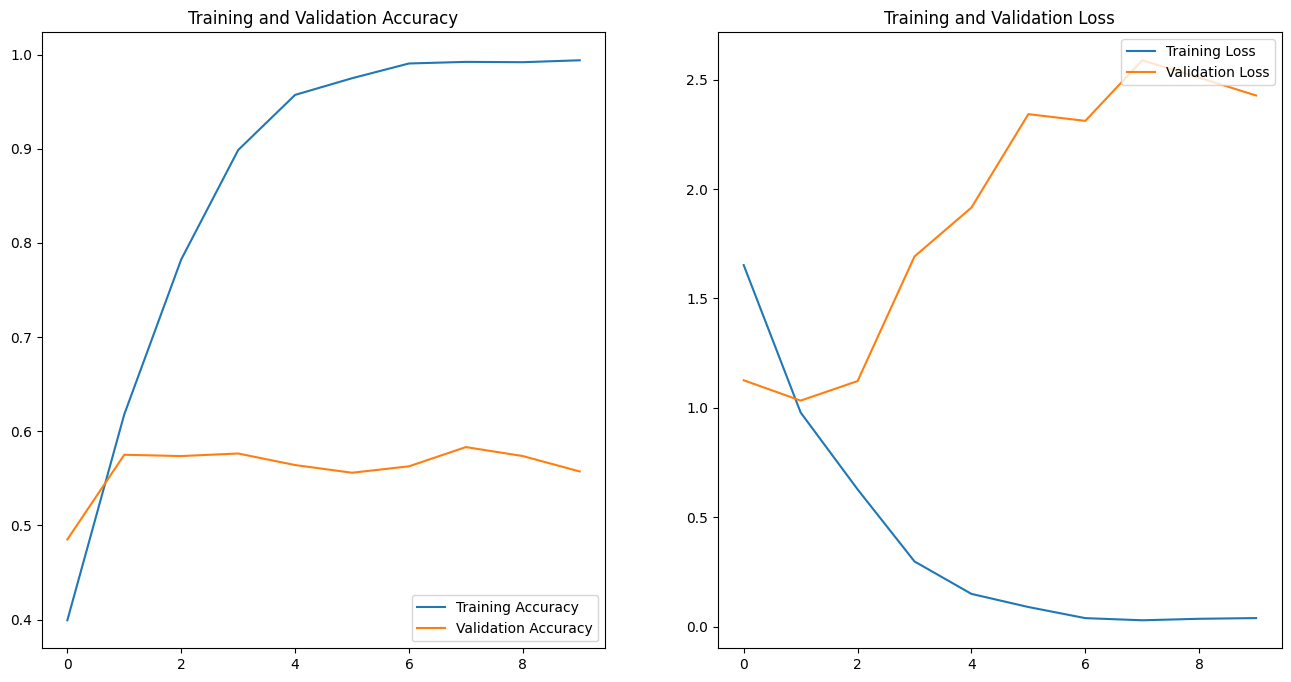

In [40]:
# Le modèle
model_with_dropout =  Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])
# Compilation du modèle
model_with_dropout.compile(optimizer =  'adam',
              loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# Résumé du modèle
model_with_dropout.summary()
# Enrainement du modèle
history =  model_with_dropout.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Qu'observe-ton au niveau de la perte et de la précision ?
<em>À COMPLÉTER</em>

Passons donc à l'augmentation de données. La couche correspondante vous est fournie ci-dessous. Cette couche parcourt le jeu de données d’entrainement et applique des transformations sur certaines images choisies aléatoirement pour augmenter le jeu de données. On peut imaginer plusieurs types de modifications, en l'occurrence les transformations qu'on va appliquer à chaque image selon une certaine probabilité sont un inversement horizontale de l’image suivi d’une rotation de 18 degrés pour finir avec un zoom vertical de 10%. Complétez-la puis exécutez-la.

In [46]:
from keras.src.layers.preprocessing.image_preprocessing import HORIZONTAL_AND_VERTICAL
from keras.src.layers.preprocessing.image_preprocessing import RandomFlip
from keras.src.layers.preprocessing.image_preprocessing import RandomRotation
from keras.src.layers.preprocessing.image_preprocessing import RandomZoom
from keras import Sequential

data_augmentation = Sequential(
  [
      RandomFlip(
          mode=HORIZONTAL_AND_VERTICAL,
          input_shape=(image_h, image_w, 3)),
      RandomRotation(
          factor=0.18,
          fill_mode='reflect',
          interpolation='bilinear',
          seed=None,
          fill_value=0.0),
      RandomZoom(
          height_factor=0.1,
          width_factor=None,
          fill_mode='reflect',
          interpolation='bilinear',
          seed=None,
          fill_value=0.0)
  ]
)

Rajoutez ensuite l'augmentation des données à votre CNN et vérifiez les courbes obtenues après entrainement et évaluation du modèle.

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 conv2d_22 (Conv2D)          (None, 90, 90, 64)        18496     
                                                      

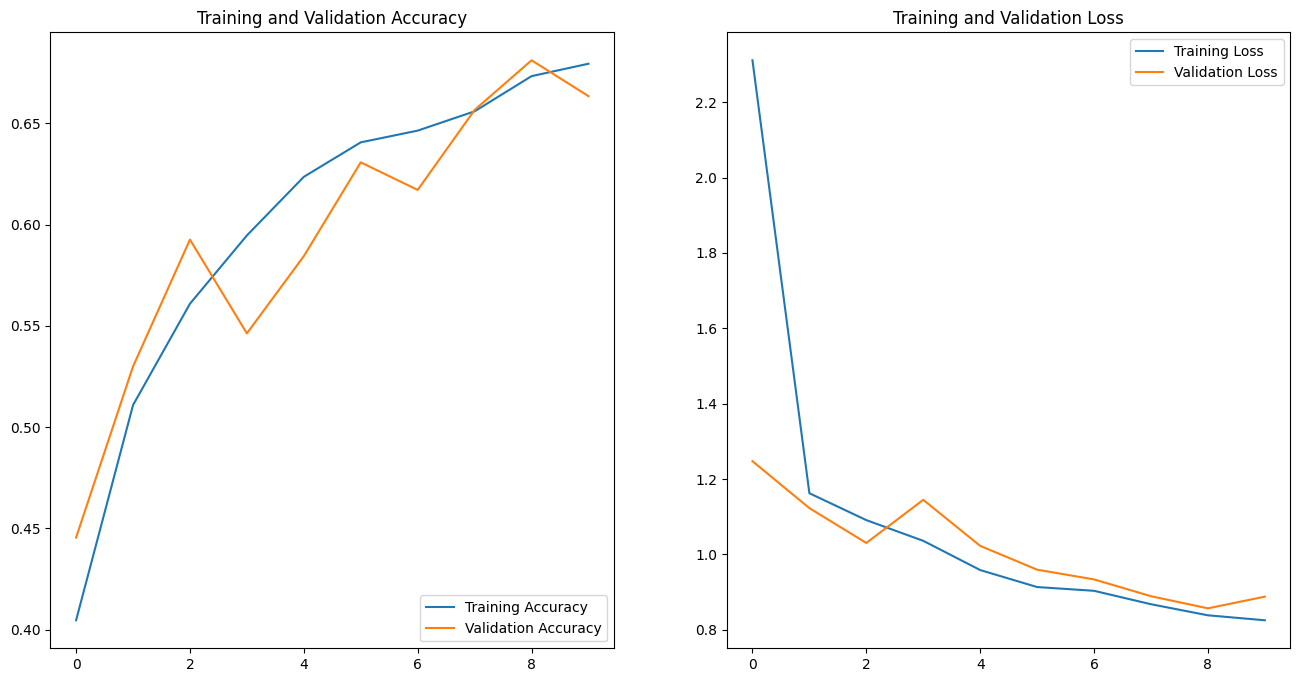

In [47]:
# Le modèle
complete_model =  Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    data_augmentation,
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])
complete_model.build((None, image_h, image_w, 3))
# Compilation du modèle
complete_model.compile(optimizer =  'adam',
              loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# Résumé du modèle
complete_model.summary()
# Enrainement du modèle
history =  complete_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs
)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Nous observons cette fois une nette amélioration des performances, la précision dans le jeu de test atteint une valeur proche de la précision dans le jeu d’entrainement, et la perte du jeu de test baisse de façon quasi continuelle au cours de l’entrainement. Voilà une bonne nouvelle. Que remarquez-vous d'autre ?
<em>À COMPLÉTER</em>


# 6. Conclusion

Bravo, Vous venez de réaliser votre premier CNN ! Vous avez vu comment implémenter, entrainer et évaluer un CNN ainsi qu’améliorer ses performances grâce à la régularisation. Félicitations !

Mais il vous reste encore beaucoup à apprendre. Tout d'abord, la précision qu'on obtient n’est que de 73% (celle-ci peut être très proche des 100% pour des jeux de données comme MNIST). Ceci n’est pas étonnant vue la taille de votre réseau qui est très petite (le nombre de paramètres des RNs de Google, par exemple, peut atteindre le million voire le milliard).

Évidemment, augmenter la taille du réseau va nettement impacter la rapidité de l'apprentissage. Dans ce cas, l'usage de GPU performants peut améliorer vos performances de manière drastiques, ceux-ci sont très efficaces pour exécuter des  taches de vision. TensorFlow le fait par défaut, mais il est parfois nécessaire d'adapter son fonctionnement, comme par exemple sélectionner le bon GPU (notamment si vous avez un CPU avec un GPU intégré, en général peu performant, et un GPU externe plus puissant). Vous devriez pouvoir trouverfacilement des [ressources abordant le sujet](https://stackoverflow.com/questions/53065420/by-default-does-tensorflow-use-gpu-cpu-simultaneously-for-computing-or-gpu-only).

Il y aurait surement d'autres approches pour améliorer les résultats. Il exister des arhitectures plus évoluées de CNNs, comme par exemple ResNet, qui connecte des couches profondes avec des couches mois profondes.

Et puis, ici on n'a abordé qu’une seule tache de vision par ordinateur, la classification. Or, c'est la plus simple, et celle-ci est rarement utile à elle seule dans un contexte applicatif (comme pour les voitures autonomes, par exemple). Il y a beaucoup d’autres taches de vision par ordinateur toutes plus difficiles les unes que les autres, comme la détection d’objets (mettre des boites et des labels autour des objets), la segmentation d’image (classifier chaque pixel), la reconnaissance faciale, la restauration d’images etc.